In [1]:
import cvxopt
import pickle as pkl
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import optimize
from sklearn.metrics import roc_auc_score
from utils_eugene import get_all_atom_types, weisfeiler_lehman, clean_dataset, WLK_linear, WLK_gaussian, WL
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
cvxopt.solvers.options['show_progress'] = False

Reading the data:

In [3]:
with open('data/training_data.pkl', 'rb') as file:
    train_graphs = pkl.load(file)

with open('data/test_data.pkl', 'rb') as file:
    test_graphs = pkl.load(file)

with open('data/training_labels.pkl', 'rb') as file:
    train_labels = pkl.load(file)

Cleaning the data:

In [4]:
#train_graphs = clean_dataset(train_graphs)

Plotting the data:

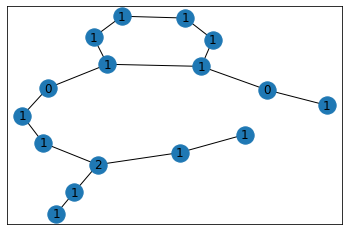

In [5]:
idx=0
nx.draw_networkx(train_graphs[idx], labels=get_all_atom_types(train_graphs[idx]))

Kernel SVC that takes as input the Gram matrices:

In [6]:
class KernelSVC:
    def __init__(self, C, epsilon = 1e-3):
        self.C = C
        self.alpha = None
        self.epsilon = epsilon
    
    def fit(self, G, y, method="cvxopt", class_weights=True):
        N = len(y)
        K = G
        y = y*2-1 # rescaling values to -1, 1
        self.y = y

        assert (np.unique(y) == np.array([-1, 1])).all(), print('y must take values in [-1, 1]')

        if type(class_weights) == dict:
            Cvect = self.C * class_weights[-1] * (self.y == -1) + self.C * class_weights[1] * (self.y == 1)
        elif class_weights:
            Cvect = self.C * (N / np.sum((self.y==-1))) * (self.y == -1) + self.C * (N / np.sum((self.y==1))) * (self.y == 1)
        else:
            Cvect = self.C * np.ones(N)

        if method=="scipy":
            # Lagrange dual problem
            def loss(alpha):
                ay = np.multiply(alpha, y)
                return 0.5*np.dot(ay, K@ay) - np.sum(alpha)

            # Partial derivate of Ld on alpha
            def grad_loss(alpha):
                return np.dot(np.diag(y)@K@np.diag(y), alpha) - np.ones(N)

            # function defining the equality constraint
            fun_eq = lambda alpha: np.dot(alpha, y)
            # jacobian wrt alpha of the  equality constraint
            jac_eq = lambda alpha: y
            # function defining the inequality constraint
            fun_ineq = lambda alpha: (
                np.append(np.zeros(N), self.C*np.ones(N)) - np.vstack((-np.eye(N), np.eye(N)))@alpha
            )
            # jacobian wrt alpha of the  inequality constraint
            jac_ineq = lambda alpha: - np.vstack((-np.eye(N), np.eye(N)))
            
            constraints = ({'type': 'eq', 'fun': fun_eq, 'jac': jac_eq},
                        {'type': 'ineq', 'fun': fun_ineq, 'jac': jac_ineq})

            optRes = optimize.minimize(
                fun=lambda alpha: loss(alpha),
                x0=np.ones(N),
                method='SLSQP',
                jac=lambda alpha: grad_loss(alpha),
                constraints=constraints,
                options={'disp': True}
            )
            self.alpha = optRes.x

            # Useful to simplify notations:
            ay = np.multiply(self.alpha, y)

            # Indices of support vectors:
            support_idx = np.where((self.alpha < self.C - self.epsilon) & (self.alpha > self.epsilon))
            print(f'Found {len(support_idx)} support vectors.')

            # Offset of the classifier
            self.b = np.median(y[support_idx] - K[support_idx]@ay)
            print(f'b = {self.b}')

            # RKHS norm of the function f
            self.norm_f = np.sqrt(np.dot(ay, K@ay))
            print(f'||f|| = {self.norm_f}')

        elif method == "cvxopt":
            # Quadratic objective
            P = np.diag(self.y) @ K @ np.diag(self.y)
            q = -np.ones(N)

            # Constraints
            G = np.kron(np.array([[-1.0], [1.0]]), np.eye(N))
            h = np.kron(np.array([0.0, 1.0]), Cvect)
            A = self.y.reshape(1, -1).astype("float")
            b = np.array([[0.0]]).astype("float")

            # Optimization
            out = cvxopt.solvers.qp(
                P=cvxopt.matrix(P),
                q=cvxopt.matrix(q),
                G=cvxopt.matrix(G),
                h=cvxopt.matrix(h),
                A=cvxopt.matrix(A),
                b=cvxopt.matrix(b),
            )
            self.alpha = np.array(out["x"]).reshape((N,))

    ### Implementation of the separating function $f$
    def separating_function(self, G):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        ay = np.multiply(self.alpha, self.y)
        return G@ay
    
    def predict(self, G):
        """ Predict y values in {0, 1} """
        d = self.separating_function(G)
        return d > 0 # +self.b)

Building the full Gram Matrix:

In [7]:
max_iter = 2
normalize = True

N_train = len(train_graphs)
indexes_train = np.arange(N_train)

N_test = len(test_graphs)
indexes_test = np.arange(N_test)

X_train = []
for i in indexes_train:
    X_train.append(WL(train_graphs[i], max_iter=max_iter, normalize=normalize))

X_test = []
for i in indexes_test:
    X_test.append(WL(test_graphs[i], max_iter=max_iter, normalize=normalize))

AssertionError: 

In [8]:
G_train = np.zeros((N_train, N_train))
for i in tqdm(range(N_train)):
    for j in range(i, N_train):
        g = WLK_gaussian(X_train[i], X_train[j])
        G_train[i,j] = g
        G_train[j,i] = g

  4%|▍         | 242/6000 [00:19<07:42, 12.45it/s]


KeyboardInterrupt: 

In [9]:
G_test = np.zeros((N_test, N_train))
for i in tqdm(range(N_test)):
    for j in range(N_train):
        G_test[i,j] = WLK_gaussian(X_test[i], X_train[j])

100%|██████████| 2000/2000 [04:02<00:00,  8.25it/s]


In [10]:
sigma = 2.
G_train_exp = np.exp(-0.5*G_train/(sigma**2))
G_test_exp = np.exp(-0.5*G_test/(sigma**2))

Folds for cross validation:

In [11]:
n_fold = 5

np.random.seed(42)
np.random.shuffle(indexes_train)
print(indexes_train[:5])

folds = np.split(indexes_train, n_fold)

[1782 3917  221 2135 5224]


Cross validation:

In [12]:
C=50.
class_weights = {1:3, -1:1}

models = []
scores = []
test_preds = []

for i in range(n_fold):
    print(f'##### 5-FOLD CROSS VAL: starting fold {i+1} #####')
    val_idx = folds[i]
    train_idx = list(set(indexes_train) - set(val_idx))
    
    G_train_fold = G_train_exp[train_idx][:,train_idx]
    y_train_fold = train_labels[train_idx]

    G_val_fold = G_train_exp[val_idx][:,train_idx]
    y_val_fold = train_labels[val_idx]

    G_test_fold = G_test_exp[:,train_idx]

    model = KernelSVC(C=C)
    model.fit(G_train_fold, y_train_fold, method='cvxopt', class_weights=class_weights)

    y_val_pred = model.predict(G_val_fold)
    val_score = roc_auc_score(y_val_fold, y_val_pred)
    print(f'Val score: {val_score}')

    y_test_pred = model.predict(G_test_fold)

    models.append(model)
    scores.append(val_score)
    test_preds.append(y_test_pred)

    print('\n')

##### 5-FOLD CROSS VAL: starting fold 1 #####
Val score: 0.8459114303800952


##### 5-FOLD CROSS VAL: starting fold 2 #####
Val score: 0.8170578129494166


##### 5-FOLD CROSS VAL: starting fold 3 #####
Val score: 0.8375566376108969


##### 5-FOLD CROSS VAL: starting fold 4 #####
Val score: 0.8118784790211284


##### 5-FOLD CROSS VAL: starting fold 5 #####
Val score: 0.8011047658214242




In [15]:
np.mean(scores)

0.8227018251565923

In [14]:
y_test_pred = np.mean(test_preds, axis=0)

### Old implementation

In [6]:
#from sklearn.model_selection import train_test_split

In [7]:
#train_idx, val_idx = train_test_split(range(len(train_graphs)), test_size=0.2, random_state=42)
train_idx = range(6000)
N_train = len(train_idx)
# N_val = len(val_idx)
N_test = len(test_graphs)

In [9]:
max_iter = 2

X_train = []
for i in train_idx:
    X_train.append(WL(train_graphs[i], max_iter=max_iter))
    #X_train.append(weisfeiler_lehman(train_graphs[i], h=3))

# X_val = []
# for i in val_idx:
#     X_val.append(WL(train_graphs[i], max_iter=max_iter))
#     #X_val.append(weisfeiler_lehman(train_graphs[i], h=3))

X_test = []
for i in range(N_test):
    X_test.append(WL(test_graphs[i], max_iter=max_iter))
    #X_val.append(weisfeiler_lehman(train_graphs[i], h=3))

y_train = train_labels[train_idx]
# y_val = train_labels[val_idx]

Computing the Gram matrices:

In [10]:
G_train = np.zeros((N_train, N_train))
for i in tqdm(range(N_train)):
    for j in range(i, N_train):
        g = WLK_gaussian(X_train[i], X_train[j])
        G_train[i,j] = g
        G_train[j,i] = g

100%|██████████| 6000/6000 [03:27<00:00, 28.96it/s] 


In [10]:
# G_val = np.zeros((N_val, N_train))
# for i in tqdm(range(N_val)):
#     for j in range(N_train):
#         G_val[i,j] = WLK_gaussian(X_val[i], X_train[j])

100%|██████████| 1200/1200 [01:52<00:00, 10.63it/s]


In [11]:
G_test = np.zeros((N_test, N_train))
for i in tqdm(range(N_test)):
    for j in range(N_train):
        G_test[i,j] = WLK_gaussian(X_test[i], X_train[j])

100%|██████████| 2000/2000 [02:41<00:00, 12.37it/s]


### Fitting SVC:

In [12]:
# RBF Kernel:
sigma = 2.
G_train_exp = np.exp(-0.5*G_train/(sigma**2))
#G_val_exp = np.exp(-0.5*G_val/(sigma**2))
G_test_exp = np.exp(-0.5*G_test/(sigma**2))

In [13]:
C=10.
model = KernelSVC(C=C)
model.fit(G_train_exp, y_train, method='cvxopt', class_weights={-1:1, 1:3})

     pcost       dcost       gap    pres   dres
 0:  3.5217e+04 -1.0811e+06  2e+06  3e-01  2e-14
 1:  2.9989e+04 -1.7792e+05  2e+05  2e-02  1e-14
 2:  8.8048e+03 -5.0577e+04  6e+04  5e-03  1e-14
 3:  3.1205e+03 -2.7378e+04  3e+04  2e-03  7e-15
 4: -7.3351e+02 -6.9843e+03  6e+03  2e-04  7e-15
 5: -1.3262e+03 -4.2104e+03  3e+03  5e-05  4e-15
 6: -1.5737e+03 -2.3794e+03  8e+02  1e-05  4e-15
 7: -1.6219e+03 -1.9077e+03  3e+02  4e-06  3e-15
 8: -1.6362e+03 -1.7464e+03  1e+02  7e-14  4e-15
 9: -1.6419e+03 -1.6642e+03  2e+01  2e-13  3e-15
10: -1.6433e+03 -1.6480e+03  5e+00  1e-13  3e-15
11: -1.6437e+03 -1.6443e+03  6e-01  9e-14  3e-15
12: -1.6438e+03 -1.6439e+03  1e-01  7e-14  3e-15
13: -1.6438e+03 -1.6438e+03  1e-02  5e-14  3e-15
14: -1.6438e+03 -1.6438e+03  3e-04  3e-14  3e-15
Optimal solution found.


In [14]:
y_train_pred = model.predict(G_train_exp)
# y_val_pred = model.predict(G_val_exp)
y_test_pred = model.predict(G_test_exp)

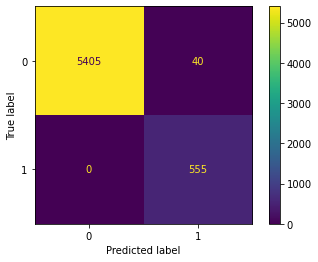

In [15]:
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()
plt.show()

In [16]:
roc_auc_score(y_train, y_train_pred)

0.9963269054178144

#### Fitting kNN:

In [10]:
def kNN(G_val, y_train, k=3):
    """
    Given a feature dictionnary whose label is to be predicted, the WL feature vector of the graphs in the training set 
    and the number of nearest neighbors k, returns the predicted label of G.
    """
    neighbours = np.argpartition(G_val, k, axis=1)[:,:k]

    y_pred = []
    for i in range(len(neighbours)):
        is_positive = sum([y_train[i] for i in neighbours[i]])
        if is_positive > k/2 :
            y_pred.append(1)
        else:
            y_pred.append(0)
    return np.array(y_pred)

In [23]:
y_pred = kNN(G_val, y_train, k=1)

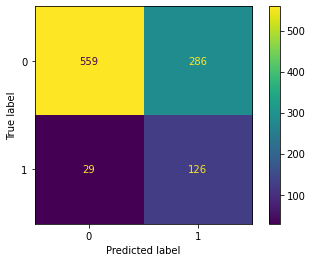

In [27]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()
plt.show()

In [70]:
y_pred.sum()/len(y_pred)

0.298

## Submission:

In [36]:
Yte = {'Predicted' : np.array(y_test_pred, dtype=np.float32)}
dataframe = pd.DataFrame(Yte)
dataframe.index += 1
dataframe.to_csv('test_pred.csv', index_label='Id')